In [161]:
####
# @author: Nwamaka Nzeocha and Fabian Okeke
# @course: CS 5304/Data Science in the Wild
####

# Environment setup

**useful tensor flow notebook:**
 - http://bit.ly/1NjhcfQ
 - http://katbailey.github.io/post/neural-nets-in-python/
 - https://medium.com/@ilblackdragon/tensorflow-tutorial-part-1-c559c63c0cb1#.al2qi7pab

**libraries:**
 - pip install https://storage.googleapis.com/tensorflow/mac/tensorflow-0.8.0-py2-none-any.whl 
 - pip install numpy scipy scikit-learn matplotlib

**dataset:**
 - https://s3.amazonaws.com/giyengar-cs5304/a4_smvl_tst.gz
 - https://s3.amazonaws.com/giyengar-cs5304/a4_smvl_val.gz
 - https://s3.amazonaws.com/giyengar-cs5304/a4_smvl_trn.gz

# Add libraries and relevant functions

In [21]:
import random
import os.path
import numpy as np

from sklearn import metrics
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import SGDClassifier
from sklearn.datasets import load_svmlight_file
from tensorflow.contrib import learn

from time import time

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline



#############
# helper functions
#############

def exists(filepath):
    """
    Check if file or dir exists
        
    
    Parameters
    -----
    filepath: location of file or dir    
    
    
    Returns
    ------
    True if file/dir exists in filepath else False
    """
    return os.path.exists(filepath)



def get_data(filepath):
    """
    Retrieve data in svm_light format
    
    
    Parameters
    -----
    filepath: location of file    
    
    
    Returns
    ------
    tuple of numpy arrays: X, y   
    """
    start = time()
    data = load_svmlight_file(filepath)
    print 'Loading duration(secs):', time() - start
    return data[0].toarray(), (data[1]+1)/2


def get_model_results(model, training_data, test_data):
    """
    Find the best hyper parameters for model given the training and test data
    
    
    Parameters
    -----
    model: machine learning model such as Logistic Regression, MultiLayer Perceptron
    
    training_data: list containing X,y training data
    
    test_data: list containing test X,y test data
    
    
    Returns
    ------
    y_proba, y_pred y_test, accuracy, auc, brier_loss
    """
    
    # choose model
    if model == "LR":
        model = LogisticRegression()
    elif model == "TF":
        model = learn.TensorFlowDNNClassifier(hidden_units=[150, 40], n_classes=2, steps=1000, batch_size=25, learning_rate=0.0002, optimizer="Adam")
     
    # fit model
    start = time()
    X_train, y_train = training_data
    X_test, y_test = test_data
    model.fit(X_train, y_train)
    
    # accuracy
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)

    # auc
    y_proba = model.predict_proba(X_test)
    auc = metrics.roc_auc_score(y_test, (y_proba[:,1] - y_proba[:,0]))
            
    print 'Accuracy: {0:f}'.format(accuracy)
    print 'AUC: {0:f}'.format(auc)
    
    # brier loss
    brier_loss = metrics.brier_score_loss(y_test, y_proba[:,1], pos_label=1)

    print 'Model computation duration (secs):', time() - start
    return (y_proba, y_pred, y_test, accuracy, auc, brier_loss)

# Download files if they don't exist

In [180]:
if exists('a4_smvl_trn.gz') and exists('a4_smvl_val.gz') and exists('a4_smvl_tst.gz'):
    print 'Dataset available. Continue...'
else:
    'Download these files: (a4_smvl_trn.gz, a4_smvl_val.gz, a4_smvl_tst.gz) before you continue.'
    # os.system('wget xyz')

Dataset available. Continue...


# Load dataset

In [14]:
# gunzip -c a4_smvl_trn.gz | head -n 100000 |  gshuf | head -n 100000 > trainSmall
X_train, y_train = get_data('trainSmall')

Loading duration(secs): 18.4896218777


In [15]:
# gunzip -c a4_smvl_tst.gz | head -n 100000 |  gshuf | head -n 100000 > testSmall
X_test, y_test = get_data('testSmall')

Loading duration(secs): 17.9071471691


# Dataset shape

In [184]:
# limit to size 100K since performance is still good
print X_train.shape
print X_test.shape

(100000, 18898)
(100000, 18898)


# Get results for LR

In [9]:
results_LR = get_model_results("LR", [X_train, y_train], [X_test, y_test])
print "****Results_LR done****"

Accuracy: 0.923520
AUC: 0.956351
Model computation duration (secs): 117.42782712
****Results_LR done****


# Get results for Tensor Flow MLP

In [19]:
results_TF = get_model_results("TF", [X_train, y_train], [X_test, y_test])
print "****Results_TF done****"

Step #99, avg. train loss: 0.39923
Step #199, avg. train loss: 0.25701
Step #299, avg. train loss: 0.22874
Step #399, avg. train loss: 0.22911
Step #499, avg. train loss: 0.19520
Step #599, avg. train loss: 0.20583
Step #699, avg. train loss: 0.19608
Step #799, avg. train loss: 0.17974
Step #899, avg. train loss: 0.20368
Step #999, avg. train loss: 0.18764
Accuracy: 0.925810
AUC: 0.954082
Model computation duration (secs): 228.184405088
****Results_TF done****


# ROC curves, Brier Score, Accuracy scores, AUC scores

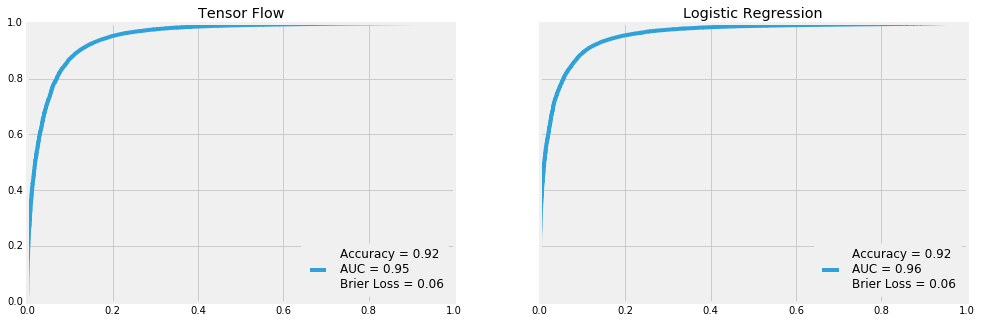

In [10]:
y_predictions = {
    'Logistic Regression': results_LR,
    'Tensor Flow': results_TF
}

fig, axes = plt.subplots(1, len(y_predictions), sharey=True)
fig.set_size_inches(15,5)
i = 0

for title, results in y_predictions.items():
    y_proba, y_pred, y_test, accuracy, auc, brier_loss = results
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, (y_proba[:,1] - y_proba[:,0]))
    
    label = 'Accuracy = %0.2f \nAUC = %0.2f \nBrier Loss = %0.2f' % (accuracy, auc, brier_loss)
    axes[i].plot(fpr, tpr, label=label)
    axes[i].set_title(title)
    axes[i].legend(loc='lower right')
    i += 1